In [122]:
import pandas as pd 
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
pd.options.mode.chained_assignment = None  # default='warn'

In [123]:
df = pd.read_csv("https://raw.githubusercontent.com/slavaspirin/Toronto-housing-price-prediction/master/houses.csv")
original_data = df.copy()
df.head()

,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code
0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2 baths,800–899 sq. ft.,1 parking,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76
1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14
2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1 beds,1 baths,500–599 sq. ft.,no parking,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104
3,3,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,1 + 1 beds,1 baths,600–699 sq. ft.,1 parking,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82
4,4,"61 Twelfth St, Toronto (W4519375) | Zoocasa",825513,839000,2 beds,2 baths,N/A sq. ft.,1 parking,Location! Location! Location. Your Cottage In ...,W4519375,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"61 Twelfth St, Toronto , Ontario, Canada",43.597096,-79.509612,New Toronto,44101,18


In [124]:
def cleansing_function(df):
    df = df.copy()
    abnType = df['type'].unique()[5] ## taking out the abnormal hosue type
    df = df[df['type']!= abnType]
    ## checking all the cities that are in the data

    '''
    we are going to split the data using the "," and then split based on teh space and get the city from each one,

    This will be added to a new column called "city"
    '''
    df["city"] = df["full_address"].apply(lambda x: x.split(",")[1].split(" ")[1].upper())
    ## now we will exclude the only row with the value "OUT" as city

    df = df[df["city"] != "OUT"]
    ## now let's clean the bedrooms column

    df["bedrooms"] = df["bedrooms"].apply(lambda x: ' '.join(x.split(" ")))

    for i,n in enumerate(df["bedrooms"]):
        df["bedrooms"].iloc[i] = max([int(s) for s in n.split() if s.isdigit()])
    ## now let's clean the bathrooms column

    df["bathrooms"] = df["bathrooms"].apply(lambda x: int(''.join(x.lower()).replace("baths", '')))
    ## now let's clean the parking column
    df["parking"] = df["parking"].apply(lambda x:    str(x).replace('no parking', '0')  )
    df["parking"] = df["parking"].apply(lambda x:    int(str(x).replace(' parking', '')  ))
    
    ## cleaning the type column

    df["type"] = df["type"].str.upper()

    for i,t in enumerate(df["type"]):
        if "APT" in t:
            df["type"].iloc[i] = "APT"
        elif "CONDO" in t:
            df["type"].iloc[i] = "CONDO"
        elif "DETACHED" in t:
            df["type"].iloc[i] = "DETACHED_HOUSE"
        elif "TWNHOUSE" in t:
            df["type"].iloc[i] = "TWNHOUSE"
    df["type"] = df["type"][df["type"] != "COTTAGE"][df["type"] != "FOURPLEX"]
    
    ## counting out rows that have bathrooms more than bedrooms
    df = df.query("bedrooms >= bathrooms")
    
    ## cleaning the sqft column and applying the average on each value
    sqft = df["sqft"].str.split(" ", 1).apply(lambda x: x[0])
    sqft.replace({"N/A": "0-0"}, inplace=True)
    sqft = sqft.apply(lambda x: re.split('–|-',x))

    sqft = sqft.apply(lambda x: min(int(x[0]) , int(x[1])))
    sqft.replace({0: np.nan}, inplace=True)
    df["sqft"] = sqft
    
    frames = []
    for room in list(set(df['bedrooms'])):
        df_rooms = df[df['bedrooms']== room]
        df_rooms['sqft'].fillna(df_rooms['sqft'].min(),inplace = True)
        frames.append(df_rooms)
    final_df = pd.concat(frames)
    final_df = final_df.reset_index().drop(columns=['index', 'level_0'])
    final_df["sqft"] = final_df["sqft"].round()
    df = final_df
    return df


In [125]:
df = cleansing_function(df)
df.shape

(13310, 18)

In [126]:
df = df[df["final_price"]<= 2000000]

In [127]:
df.shape

(12969, 18)

In [128]:
## here we are going to categorise the final_price target
df["price_category"] = np.nan
for i,price in enumerate(df["final_price"]):
    if price <= 500000:
        df["price_category"].iloc[i] = int(0)
    elif price <= 1000000 and price > 500000:
        df["price_category"].iloc[i] = 1
    elif price <= 1500000 and price > 1000000:
        df["price_category"].iloc[i] = 2
    elif price <= 2000000 and price > 1500000:
        df["price_category"].iloc[i] = 3
df["price_category"] = df["price_category"].astype(int)

In [129]:
df["price_category"].value_counts()

1    7800
0    2780
2    1837
3     552
Name: price_category, dtype: int64

In [130]:
##. let's take the important features

df[["bedrooms", "bathrooms", "sqft", "parking", "type", "lat", "long"]]

,bedrooms,bathrooms,sqft,parking,type,lat,long
0,1,1,500.0,0,APT,43.708472,-79.397498
1,1,1,600.0,1,APT,43.638399,-79.414448
2,1,1,600.0,1,APT,43.805327,-79.220229
3,1,1,700.0,1,APT,43.769495,-79.283388
4,1,1,600.0,1,APT,43.714543,-79.453072
...,...,...,...,...,...,...,...
13299,8,8,2500.0,4,MULTIPLEX,43.718093,-79.557313
13301,9,6,2000.0,6,MULTIPLEX,43.605662,-79.498462
13305,9,9,2500.0,1,DETACHED_HOUSE,43.765282,-79.502234
13306,9,8,2000.0,2,DETACHED_HOUSE,43.768556,-79.497067


In [131]:
## let's catogorise the type column
df["type"].value_counts()

APT               6863
DETACHED_HOUSE    4558
CONDO             1103
TWNHOUSE           374
DUPLEX              24
LINK                19
TRIPLEX             19
MULTIPLEX            7
Name: type, dtype: int64

In [132]:
df["type_category"] = np.nan
for i,Type in enumerate(df["type"]):
    if Type =="APT":
        df["type_category"].iloc[i] = 0
    elif Type == "DETACHED_HOUSE":
        df["type_category"].iloc[i] = 1
    elif Type == "CONDO":
        df["type_category"].iloc[i] = 2
    elif Type == "TWNHOUSE":
        df["type_category"].iloc[i] = 3
    else:
        df["type_category"].iloc[i] = 100
df["type_category"] = df["type_category"].astype(int)
df = df[df["type_category"] != 100]
df["type_category"].value_counts()

0    6863
1    4558
2    1103
3     374
Name: type_category, dtype: int64

In [133]:
##. let's take the important features again

df[["bedrooms", "bathrooms", "sqft", "parking", "type_category", "lat", "long"]]

,bedrooms,bathrooms,sqft,parking,type_category,lat,long
0,1,1,500.0,0,0,43.708472,-79.397498
1,1,1,600.0,1,0,43.638399,-79.414448
2,1,1,600.0,1,0,43.805327,-79.220229
3,1,1,700.0,1,0,43.769495,-79.283388
4,1,1,600.0,1,0,43.714543,-79.453072
...,...,...,...,...,...,...,...
13293,8,7,2500.0,2,1,43.653484,-79.406800
13296,8,6,3500.0,2,1,43.724645,-79.441270
13305,9,9,2500.0,1,1,43.765282,-79.502234
13306,9,8,2000.0,2,1,43.768556,-79.497067


In [134]:
## let's create a dataset with the features and the target only
data_features = ["bedrooms", "bathrooms", "sqft", "parking", "type_category", "lat", "long"]
dataset = df[["bedrooms", "bathrooms", "sqft", "parking", "type_category", "lat", "long", "price_category"]]
dataset.head()

,bedrooms,bathrooms,sqft,parking,type_category,lat,long,price_category
0,1,1,500.0,0,0,43.708472,-79.397498,1
1,1,1,600.0,1,0,43.638399,-79.414448,1
2,1,1,600.0,1,0,43.805327,-79.220229,0
3,1,1,700.0,1,0,43.769495,-79.283388,0
4,1,1,600.0,1,0,43.714543,-79.453072,0


### Low Variance Filter

In [135]:
#check the variance 

dataset.var()

bedrooms               1.035634
bathrooms              0.632932
sqft              161276.099954
parking               28.844969
type_category          0.582647
lat                    0.003298
long                   0.009578
price_category         0.523462
dtype: float64

In [136]:
#Lat and long has the least variance 
#which is very less when compared to other variables so we can safely drop this

dataset=dataset.drop(['lat', 'long'],axis=1)
dataset.head()

,bedrooms,bathrooms,sqft,parking,type_category,price_category
0,1,1,500.0,0,0,1
1,1,1,600.0,1,0,1
2,1,1,600.0,1,0,0
3,1,1,700.0,1,0,0
4,1,1,600.0,1,0,0


### High Correlation Filter

In [137]:
#checking the correlation

dataset.corr()

,bathrooms,sqft,parking,type_category,price_category
bathrooms,1.000000,0.511338,0.093444,0.456034,0.484636
sqft,0.511338,1.000000,0.032385,0.220242,0.258185
parking,0.093444,0.032385,1.000000,0.051825,0.048939
type_category,0.456034,0.220242,0.051825,1.000000,0.315614
price_category,0.484636,0.258185,0.048939,0.315614,1.000000


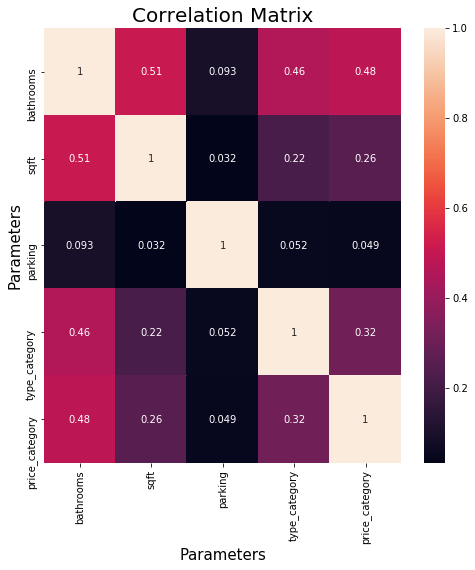

In [138]:
#Making a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (8, 8))
sns.heatmap(dataset.corr(), annot = True)
plt.title('Correlation Matrix', fontsize = 20)
plt.xlabel('Parameters', fontsize = 15) 
plt.ylabel('Parameters', fontsize = 15) 
plt.show()

In [139]:
'''since our features are not highly correlated wiht each others then we can safely 
proceed on this test wiht out dropping any features'''

'since our features are not highly correlated wiht each others then we can safely \nproceed on this test wiht out dropping any features'

### Random Forest test

In [140]:
#drop the target variable type and load this data into another dataframe

df=dataset.drop(['price_category'],axis=1)

In [141]:
## we are using the random forest to get the most important features 
#import the package for random forest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(df,dataset.price_category)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

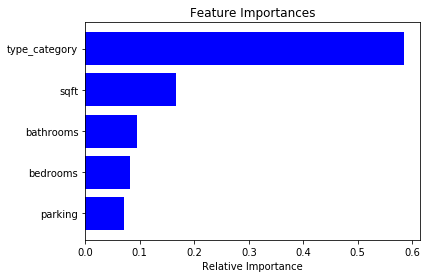

In [142]:
#Build the graph to check feature importance

features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [143]:
## Since the level of importance for the features is not that low (less than 0.5) then we can keep them

### Backword Feature Extraction

In [144]:
#import the feature selection libraries and linear regression libraries 

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lreg = LinearRegression()
rfe = RFE(lreg,n_features_to_select=3)
rfe = rfe.fit(df, dataset.price_category)

In [145]:
#check the retained column names

x_rfe = df[df.columns[rfe.support_]]
print(x_rfe.columns)

Index(['bedrooms', 'bathrooms', 'type_category'], dtype='object')


### Forward Feature Extraction

In [146]:
#import the required libraries for forward selection

from sklearn.feature_selection import f_regression
ffs = f_regression(x_rfe,dataset.price_category)

In [147]:
#Take the top most variables after the forward selection process

final_features = [ ]
for i in range(0,len(x_rfe.columns)-1):
    if ffs[0][i] >=10:
        final_features.append(df.columns[i])

In [148]:
final_features

['bedrooms', 'bathrooms']

### Building the DT Clissifier Model

In [149]:
## split the data into traing and testing
data_features = df[['bedrooms', 'bathrooms', 'type_category']]
tagret = dataset.price_category
train_X, val_X, train_y, val_y = train_test_split(data_features, target,test_size=0.2, random_state = 45)

In [150]:
#create the decision tree classifier 
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [151]:
#predicting with the test data

Y_pred = decision_tree.predict(val_X) 
print(Y_pred)

[1 1 1 ... 1 1 1]


In [152]:
#printing the accuracy score of the model

acc_decision_tree = round(decision_tree.score(train_X, train_y) * 100, 2)
print(acc_decision_tree)

62.63
